# Introduction

Motivation

## Evaluation
This competition is evaluated on the F2 Score at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
$$IoU(A,B)=\frac{A∩B}{A∪B}.$$
The metric sweeps over a range of IoU thresholds, at each point calculating an F2 Score. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.

At each threshold value t, the F2 Score value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects. The following equation is equivalent to F2 Score when β is set to 2:
$$F_\beta(t)= \frac{(1+\beta^2)⋅TP(t)}{(1+\beta^2)⋅TP(t)+\beta^2⋅FN(t)+FP(t)}.$$
A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average F2 Score of a single image is then calculated as the mean of the above F2 Score values at each IoU threshold:
$$\frac{1}{|thresholds|} \sum_t F_2(t).$$
Lastly, the score returned by the competition metric is the mean taken over the individual average F2 Scores of each image in the test dataset.
https://www.kaggle.com/c/airbus-ship-detection#evaluation

## Prizes

- 1st place - \$25,000
- 2nd place - \$15,000
- 3rd place - \$5,000
- Algorithm Speed Prize (Post competition prize) - \$15,000

The goal of the Algorithm Speed Prize is to encourage participants to develop the fastest running algorithm that will still produce accurate results. The speed prize will be open to the top performing teams on the leaderboard.

## Timeline

* July 30, 2018 - Start Date.
* September 27, 2018 - Entry deadline. 
* September 27, 2018 - Team Merger deadline.
* October 4, 2018 - Final submission deadline.
* October 18, 2018 - Final submission deadline for the Algorithm Speed Prize.
* November 22, 2018 - Announcement of the winner of the Algorithm Speed Prize.

Because of the data leak, the deadlines were extended. About the leak, in details, you can read in the next part.

# Data understanding

The original train dataset contained 104700 satellite images with 131030 ships on them. 
Test set contained 88486 images. 15 images were corrupted (1 from the train and the rest from the test). All images have resolution 768x768 px and were cut from some bigger images. No location or time data were provided in the challenge. Kaggle had reassured that there is no overlapping in the images.

Besides ships and water, the images also contain clouds, haze, wakes behind the ship (that will not count as part of the ship), coastal areas, docks, marinas, reflections, waves and other floating objects such as buoys, barges, wind turbines, etc. There is also some image cutting artifacts.

Most of the images are empty, only ~39% of them contains ships. You can see on the histogram that images with only one ship are dominating.

After a few weeks of running a severe data leak in the challenge was found: test images occurred to be just shifted train images, there were also overlaps inside train set. Then the challenge hosts provided masks also for the test set, so it can be also used for training. The new test set should be provided on the first week of October. Until that we have focused on training and validating the old data.

https://www.kaggle.com/c/airbus-ship-detection/discussion/64388

The new test set was published on 8th October. It contains only 15606 images.

# Methodology

Since the idea of the challenge was not only to achieve a good accuracy in ship detection and localization but also develop a quicker high-performance algorithm, we have suggested using some extra technic for this purpose. We wanted to compare two models, which are widely used for image segmentation and object localization: Mask R-CNN and U-net. 
U-Net was developed for the biomedical data but recently has shown good results for satellite images also. Mask R-CNN is a successor of Fast R-CNN and Faster R-CNN and now is officially a part of a Facebook's project Detectron.
Both of these models have a deep architecture and many specific heuristics to improve their precision. Both models are characterized by a big number of parameters, what makes them relatively slow in training and predictions. 
Thus, we have tried to combine them with more simple and fast (pre)classification method. On the first stage this method should scan through the images and reject the empty ones, so on the second stage, our large models will process only the selected images, which containe ships with some high probability. Consequently, we aimed to compare the accuracy and performance of Mask R-CNN and U-net on the whole test data and only on the selected during the preclassification part.
Due to some technical difficulties, we have not combined preclassification and localization blocks in one model, so the estimations of the performance improvements are based on the ratio of images, selected during the preclassification, with the whole amount of the test data. That should be considered as a low boundary of the performance improving because does not include possible parallel processing of the data through these two stages.

# Preclassification
We aimed to compare several different methods for preclassification but, because of some technical difficulties and a shortage of time, we have focused only on simple models of convolutionally neural networks. We tried different architectures and settled on two models with two convolution layers with kernels 5x5 and one linear layer:

* 8 & 16 features (CNN_8)
* 32 & 64 features (CNN_32)

Each convolutional layer was followed by ReLU function and max-pooling with kernel 2x2.
We have used cross-entropy as a loss function and stochastic gradient descent for optimization. After few tries, we chose the learning rate 0.001, the momentum 0.9 and the weight decay 0.0005. We have trained the models until the loss stops descending, that was after about 50 epochs.

We have also compared the usage of these models with the different image resize factors and balance of positive and negative examples for the training. And in the end, we have compared several of these combinations setting different thresholds on softmax functions.
For this work, we have used Pytorch

### Data preparation
There was no complete data loader for these challenge based on Pytorch, which includes all the required functions, so we developed our own using examples from the practice week and some Kaggle kernels. During the preprocessing, the images were resized and augmented. The corrupted images and images with the size smaller than 40 KB (~200 images) were dropped. 10% of the train data set was used only for validating during training.

### Resize factor
In order to accelerate the preclassification we have used instead of original 768x768 px images the resized versions of them:
* factor 2 (384x384 px)
* factor 4 (192x192 px)
* factor 8 (96x96 px)

Since some ships take only a few percents of the original images square, with the resize factor 8 they will take only several pixels and will be lost by classification. So after a short check, we rejected this factor for the detailed research.
With the resize factor 2 both models have converges to either always 1 or always 0. 

### Data balancing
One of the technics, which we have tried, is the balancing the ratio of negative examples using only 30% of empty images from train data and all the images with ships on them. In this case, the amount of positive and negative examples are approximately equal. That heuristic can be considered as not clean in data science because the structure of the train data supposed to be similar to test data, but in combination with a specific threshold on a softmax function, it gave us a suitable result for the resize factor 4.
Unfortunately, for the resize factor 2 that did not help with models convergence to extream states.

### Training
Here we show some curves of the loss function and accuracy.
We have used a simple binary accuracy: 1 if the prediction is right and 0 else. For our task it is not the optimal metric, so we have mostly focused on the confusion matrices. You can see how their values change during the training.
Here we have only two types of errors: 
* false positive, when the model predicts ships on empty images, 
* false negative, when we lose some images with ships in the next stage.

The first brings down the efficiency of the algorithm and the second - its precision. So in any case, our task is to find a trade-off between these two characteristics. We assume that the minimization of the false negative error has here a higher priority.
Previously we have predicted a class of an image just taking one of them with a maximal weight. For more precise models tuning we have passed the weights through the softmax function, which returns us values in [0,1], and compared results for different thresholds. The previous predictions will be similar to a threshold 0.5. We have decided that the optimal ratio between two errors gives us CNN_8 model with resize factor 2 trained on balanced data with the threshold 0.4.

### Predicting
After choosing the best model and resize factor we have run the preclassification on the old test data (~88k images) for two thresholds: 0.4 and 0.5. As we have previously described a data leak occurred in the challenge, so the hosts have provided masks also for this test set. According to these data we have evaluated our predictions one more time more accurate. Using 0.4 threshold we lose only ~5% of the images with ships on them but rejecting ~35% of images, thus, the performance of the next stage can be improved minimum at 1.53 times comparing to processing the whole dataset.

We did the same also for the new test set (~15k images), but in this case, the quality of classification can be observed only indirectly through the score after the second phase.


### Runtime
The model has run on an Amazon Web Service (AWS) p2.xlarge instance with the following specifications using GPU (CUDA) acceleration:
- 4 Core CPU (Intel Xeon E5‑2686 v4 Broadwell)
- 61 GB RAM
- 1 GPU (NVIDIA K80 with 2496 cores and 12 GB memory) 

One run on the old test data set (88486 images) takes on average 9:25 (min:sec) and on the new one (15606 images) - only 85 seconds, which is much faster than both models need on the second stage.

### Code

#### Python programms:
* airbus_dataloader.py - data loading and preprocessing
* airbus_models.py - used models (CNN_8 & CNN_32)
* airbus_train_val_functions.py - set of functions for training/validating and accuracy calculating
* airbus_train.py - train programm
* airbus_compare_thresholds.py - compare different thresholds on softmax function
* airbus_preclassification.py - generating the predictions

#### Jupyter notebooks:
* data_exploration.ipynb - dataset visualisation
* preclassifier_predictions.ipynb - generating the predictions
* preclassifier_predictions_analysis.ipynb - visualization of the results of predicting
* cascade_classifier_datapreparation.ipynb - datapreparation for a cascade classifier

#### Other files:
- ccc_*.py - versions for the CCC's cluster (different folders)
- ccc_negative_exaples.txt, ccc_positive_exaples.txt - dataset for the training a cascade classifier
- *.model - saved weights for models
- filtered_ships*.txt - results of the preclassification for the next stage

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
loss_df = pd.read_csv('preclassification_logs/CNN_8-32_x4_losses.csv')
loss_df.head()

,Wall time,Step,cnn_8_x4_nb,cnn_8_x4_b,cnn_32_x4
0,1.537079e+09,0,0.591707,0.677492,0.606247
1,1.537080e+09,1,0.591533,0.677106,0.598113
2,1.537080e+09,2,0.594223,0.668087,0.600391
3,1.537080e+09,3,0.594974,0.663497,0.601501
4,1.537080e+09,4,0.594768,0.662385,0.592019


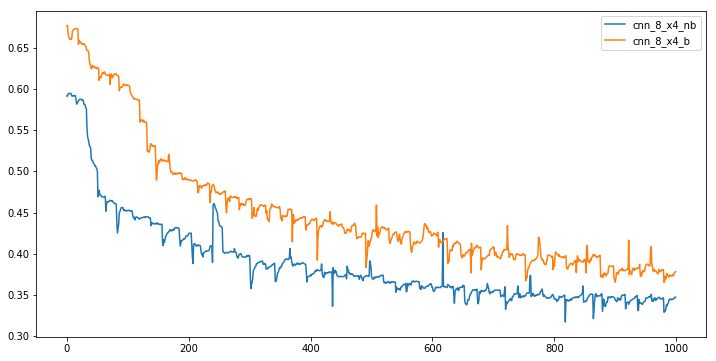

In [13]:
loss_df[['cnn_8_x4_nb', 'cnn_8_x4_b']].plot(figsize=(12,6))

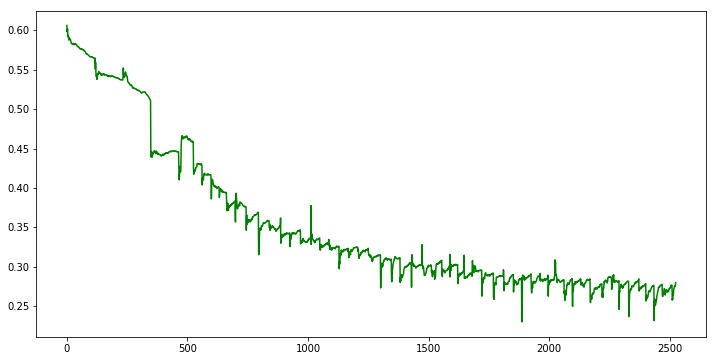

In [14]:
loss_df['cnn_32_x4'].plot(color='green', figsize=(12,6))

In [18]:
cnn8x4b = pd.read_csv('preclassification_logs/CNN_8_x4_balanced.csv')
cnn8x4b.head()

,Wall time,Step,cm00,cm01,cm10,cm11,accuracy
0,1.537026e+09,0,0.043817,0.673969,0.003940,0.278274,32.209091
1,1.537027e+09,1,0.410973,0.306813,0.062650,0.219564,63.053715
2,1.537028e+09,2,0.553858,0.163928,0.119727,0.162487,71.634476
3,1.537029e+09,3,0.420967,0.296819,0.055347,0.226867,64.783318
4,1.537030e+09,4,0.178918,0.538868,0.012492,0.269722,44.864033


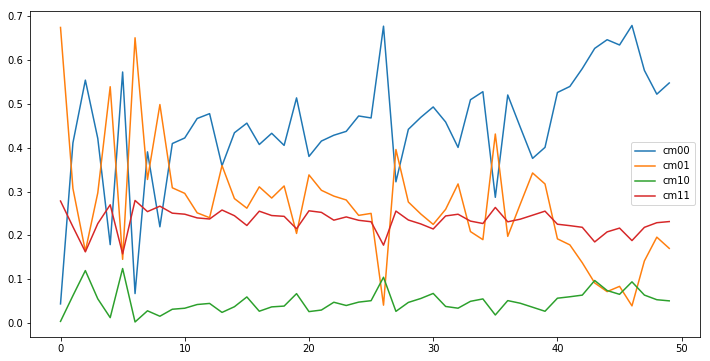

In [19]:
cnn8x4b[['cm00', 'cm01', 'cm10', 'cm11']].plot(figsize=(12,6))

In [68]:
cnn8x4nb = pd.read_csv('preclassification_logs/CNN_8_x4_notbalanced.csv')
cnn8x4nb.head()

,Wall time,Step,cm00,cm01,cm10,cm11,accuracy
0,1.537081e+09,0,0.715384,0.000000,0.284616,0.000000,71.538391
1,1.537084e+09,1,0.597771,0.117613,0.149899,0.134717,73.248772
2,1.537086e+09,2,0.702988,0.012396,0.187182,0.097434,80.042282
3,1.537088e+09,3,0.700490,0.014894,0.189680,0.094936,79.542618
4,1.537090e+09,4,0.643701,0.071683,0.134237,0.150380,79.408089


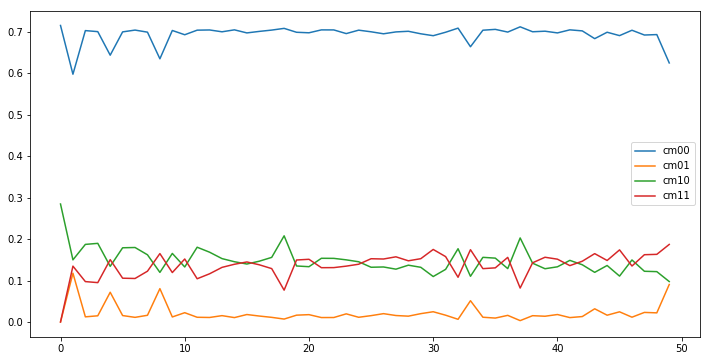

In [69]:
cnn8x4nb[['cm00', 'cm01', 'cm10', 'cm11']].plot(figsize=(12,6))

In [70]:
cnn8x4nb.tail()

,Wall time,Step,cm00,cm01,cm10,cm11,accuracy
45,1.537182e+09,45,0.690881,0.024503,0.110695,0.173921,86.480255
46,1.537184e+09,46,0.703853,0.011531,0.149611,0.135005,83.885849
47,1.537186e+09,47,0.692322,0.023061,0.122322,0.162295,85.461708
48,1.537188e+09,48,0.693379,0.022004,0.121457,0.163159,85.653885
49,1.537191e+09,49,0.624964,0.090420,0.097531,0.187086,81.204956


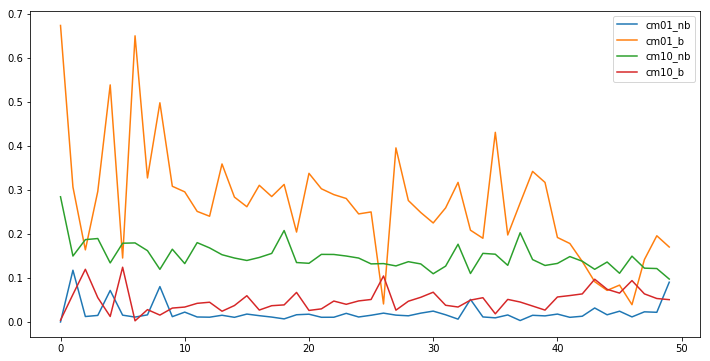

In [23]:
cnn8x4 = pd.merge(cnn8x4nb, cnn8x4b, on='Step', suffixes=('_nb', '_b'))
cnn8x4[['cm01_nb', 'cm01_b', 'cm10_nb', 'cm10_b']].plot(figsize=(12,6))

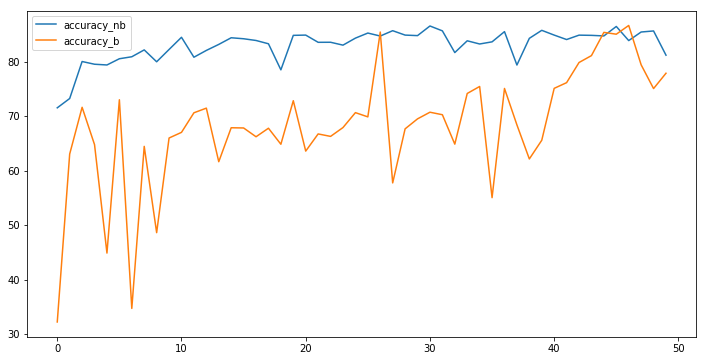

In [25]:
cnn8x4[['accuracy_nb', 'accuracy_b']].plot(figsize=(12,6))

In [27]:
cnn32x4 = pd.read_csv('preclassification_logs/cnn_32_x4.csv')
cnn32x4.head()

,Wall time,Step,cm00,cm01,cm10,cm11,accuracy
0,1.536872e+09,0,0.707601,0.001441,0.289613,0.001345,70.894592
1,1.536874e+09,1,0.498607,0.210435,0.094648,0.196310,69.491692
2,1.536876e+09,2,0.620256,0.088786,0.132795,0.158163,77.841835
3,1.536878e+09,3,0.701739,0.007303,0.197944,0.093014,79.475349
4,1.536911e+09,0,0.706832,0.014702,0.149323,0.129144,83.597580


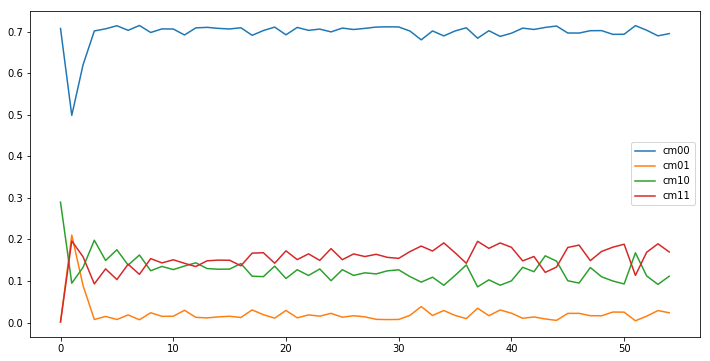

In [28]:
cnn32x4[['cm00', 'cm01', 'cm10', 'cm11']].plot(figsize=(12,6))

In [72]:
cnn8x4b_cm00 = pd.read_csv('preclassification_logs/run_tresholds_CNN_8_x4_bal_confusion matrix_00-tag-confusion_matrix.csv')
cnn8x4b_cm01 = pd.read_csv('preclassification_logs/run_tresholds_CNN_8_x4_bal_confusion matrix_01-tag-confusion_matrix.csv')
cnn8x4b_cm10 = pd.read_csv('preclassification_logs/run_tresholds_CNN_8_x4_bal_confusion matrix_10-tag-confusion_matrix.csv')
cnn8x4b_cm11 = pd.read_csv('preclassification_logs/run_tresholds_CNN_8_x4_bal_confusion matrix_11-tag-confusion_matrix.csv')
cnn8x4b_cm00.head()

,Wall time,Step,Value
0,1.537794e+09,0,0.137408
1,1.537794e+09,0,0.197752
2,1.537794e+09,0,0.255597
3,1.537794e+09,0,0.336889
4,1.537794e+09,0,0.558951


In [73]:
cnn8x4b = pd.merge(cnn8x4b_cm01, cnn8x4b_cm10, on='Wall time', suffixes=('_01', '_10'))
#cnn8x4[['cm01_nb', 'cm01_b', 'cm10_nb', 'cm10_b']].plot(figsize=(12,6))
cnn8x4b.head()

,Wall time,Step_01,Value_01,Step_10,Value_10
0,1.537794e+09,0,0.583069,0,0.001057
1,1.537794e+09,0,0.522725,0,0.001634
2,1.537794e+09,0,0.464879,0,0.003747
3,1.537794e+09,0,0.383588,0,0.008936
4,1.537794e+09,0,0.161526,0,0.034688


/home/mo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


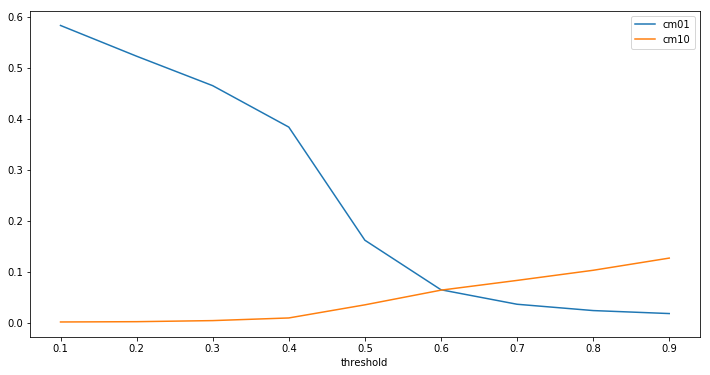

In [74]:
cnn8x4b.columns = ['time', 'threshold', 'cm01', 'step1', 'cm10']
cnn8x4b['threshold'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cnn8x4b.plot(x='threshold', y=['cm01', 'cm10'], figsize=(12,6))

/home/mo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


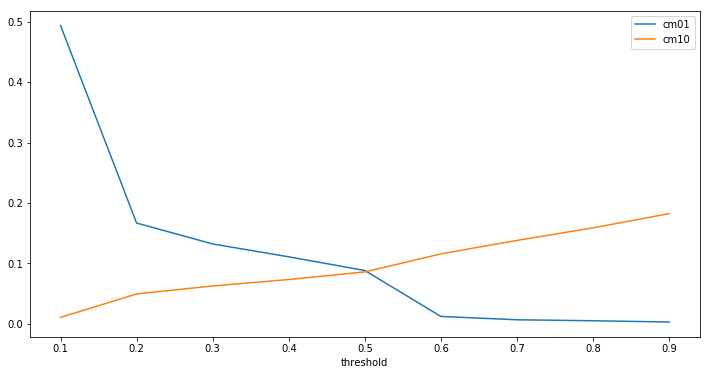

In [75]:
cnn8x4nb_cm01 = pd.read_csv('preclassification_logs/run_tresholds_CNN_8_x4_nb_confusion matrix_01-tag-confusion_matrix.csv')
cnn8x4nb_cm10 = pd.read_csv('preclassification_logs/run_tresholds_CNN_8_x4_nb_confusion matrix_10-tag-confusion_matrix.csv')
cnn8x4nb = pd.merge(cnn8x4nb_cm01, cnn8x4nb_cm10, on='Wall time', suffixes=('_01', '_10'))
cnn8x4nb.columns = ['time', 'threshold', 'cm01', 'step1', 'cm10']
cnn8x4nb['threshold'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
cnn8x4nb.plot(x='threshold', y=['cm01', 'cm10'], figsize=(12,6))

In [76]:
cnn8x4 = pd.merge(cnn8x4nb, cnn8x4b, on='threshold', suffixes=('_nb', '_b'))
cnn8x4.head()

,time_nb,threshold,cm01_nb,step1_nb,cm10_nb,time_b,cm01_b,step1_b,cm10_b
0,1.537793e+09,0.1,0.494187,0,0.010666,1.537794e+09,0.583069,0,0.001057
1,1.537793e+09,0.2,0.166907,0,0.049486,1.537794e+09,0.522725,0,0.001634
2,1.537794e+09,0.3,0.132315,0,0.062746,1.537794e+09,0.464879,0,0.003747
3,1.537794e+09,0.4,0.110983,0,0.073412,1.537794e+09,0.383588,0,0.008936
4,1.537794e+09,0.5,0.088306,0,0.086000,1.537794e+09,0.161526,0,0.034688


/home/mo/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


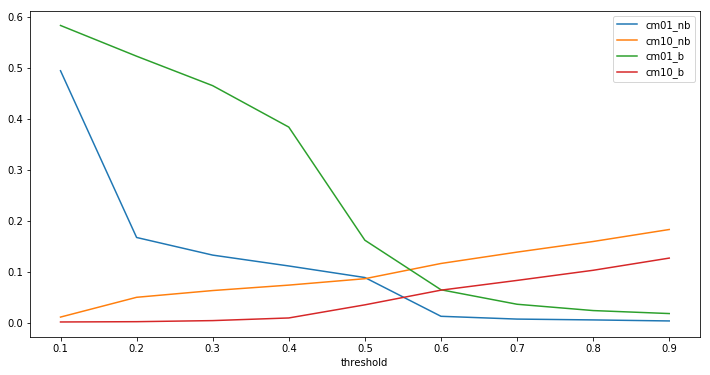

In [77]:
cnn8x4.plot(x='threshold', y=['cm01_nb', 'cm10_nb', 'cm01_b', 'cm10_b'], figsize=(12,6))

In [78]:
cnn8x4nb

,time,threshold,cm01,step1,cm10
0,1.537793e+09,0.1,0.494187,0,0.010666
1,1.537793e+09,0.2,0.166907,0,0.049486
2,1.537794e+09,0.3,0.132315,0,0.062746
3,1.537794e+09,0.4,0.110983,0,0.073412
4,1.537794e+09,0.5,0.088306,0,0.086000
5,1.537794e+09,0.6,0.012203,0,0.115884
6,1.537794e+09,0.7,0.006726,0,0.138176
7,1.537794e+09,0.8,0.005093,0,0.159028
8,1.537794e+09,0.9,0.003075,0,0.182569


In [79]:
10/4

2.5